In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split as tsp

## 下载&查看数据

In [2]:
df = pd.read_csv('pima_indian.csv')

In [3]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


坐标类：Pregnancies，Glucose，BloodPressure，SkinThickness，Insulin，BMI，DiabetesPedigreeFunction，Age
全是坐标型……
没有分类变量

In [5]:
df.isnull().any()

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

没有缺失值

In [6]:
df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

正负样本点分布不均匀

## 可视化

/home/lyf/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/home/lyf/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/lyf/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


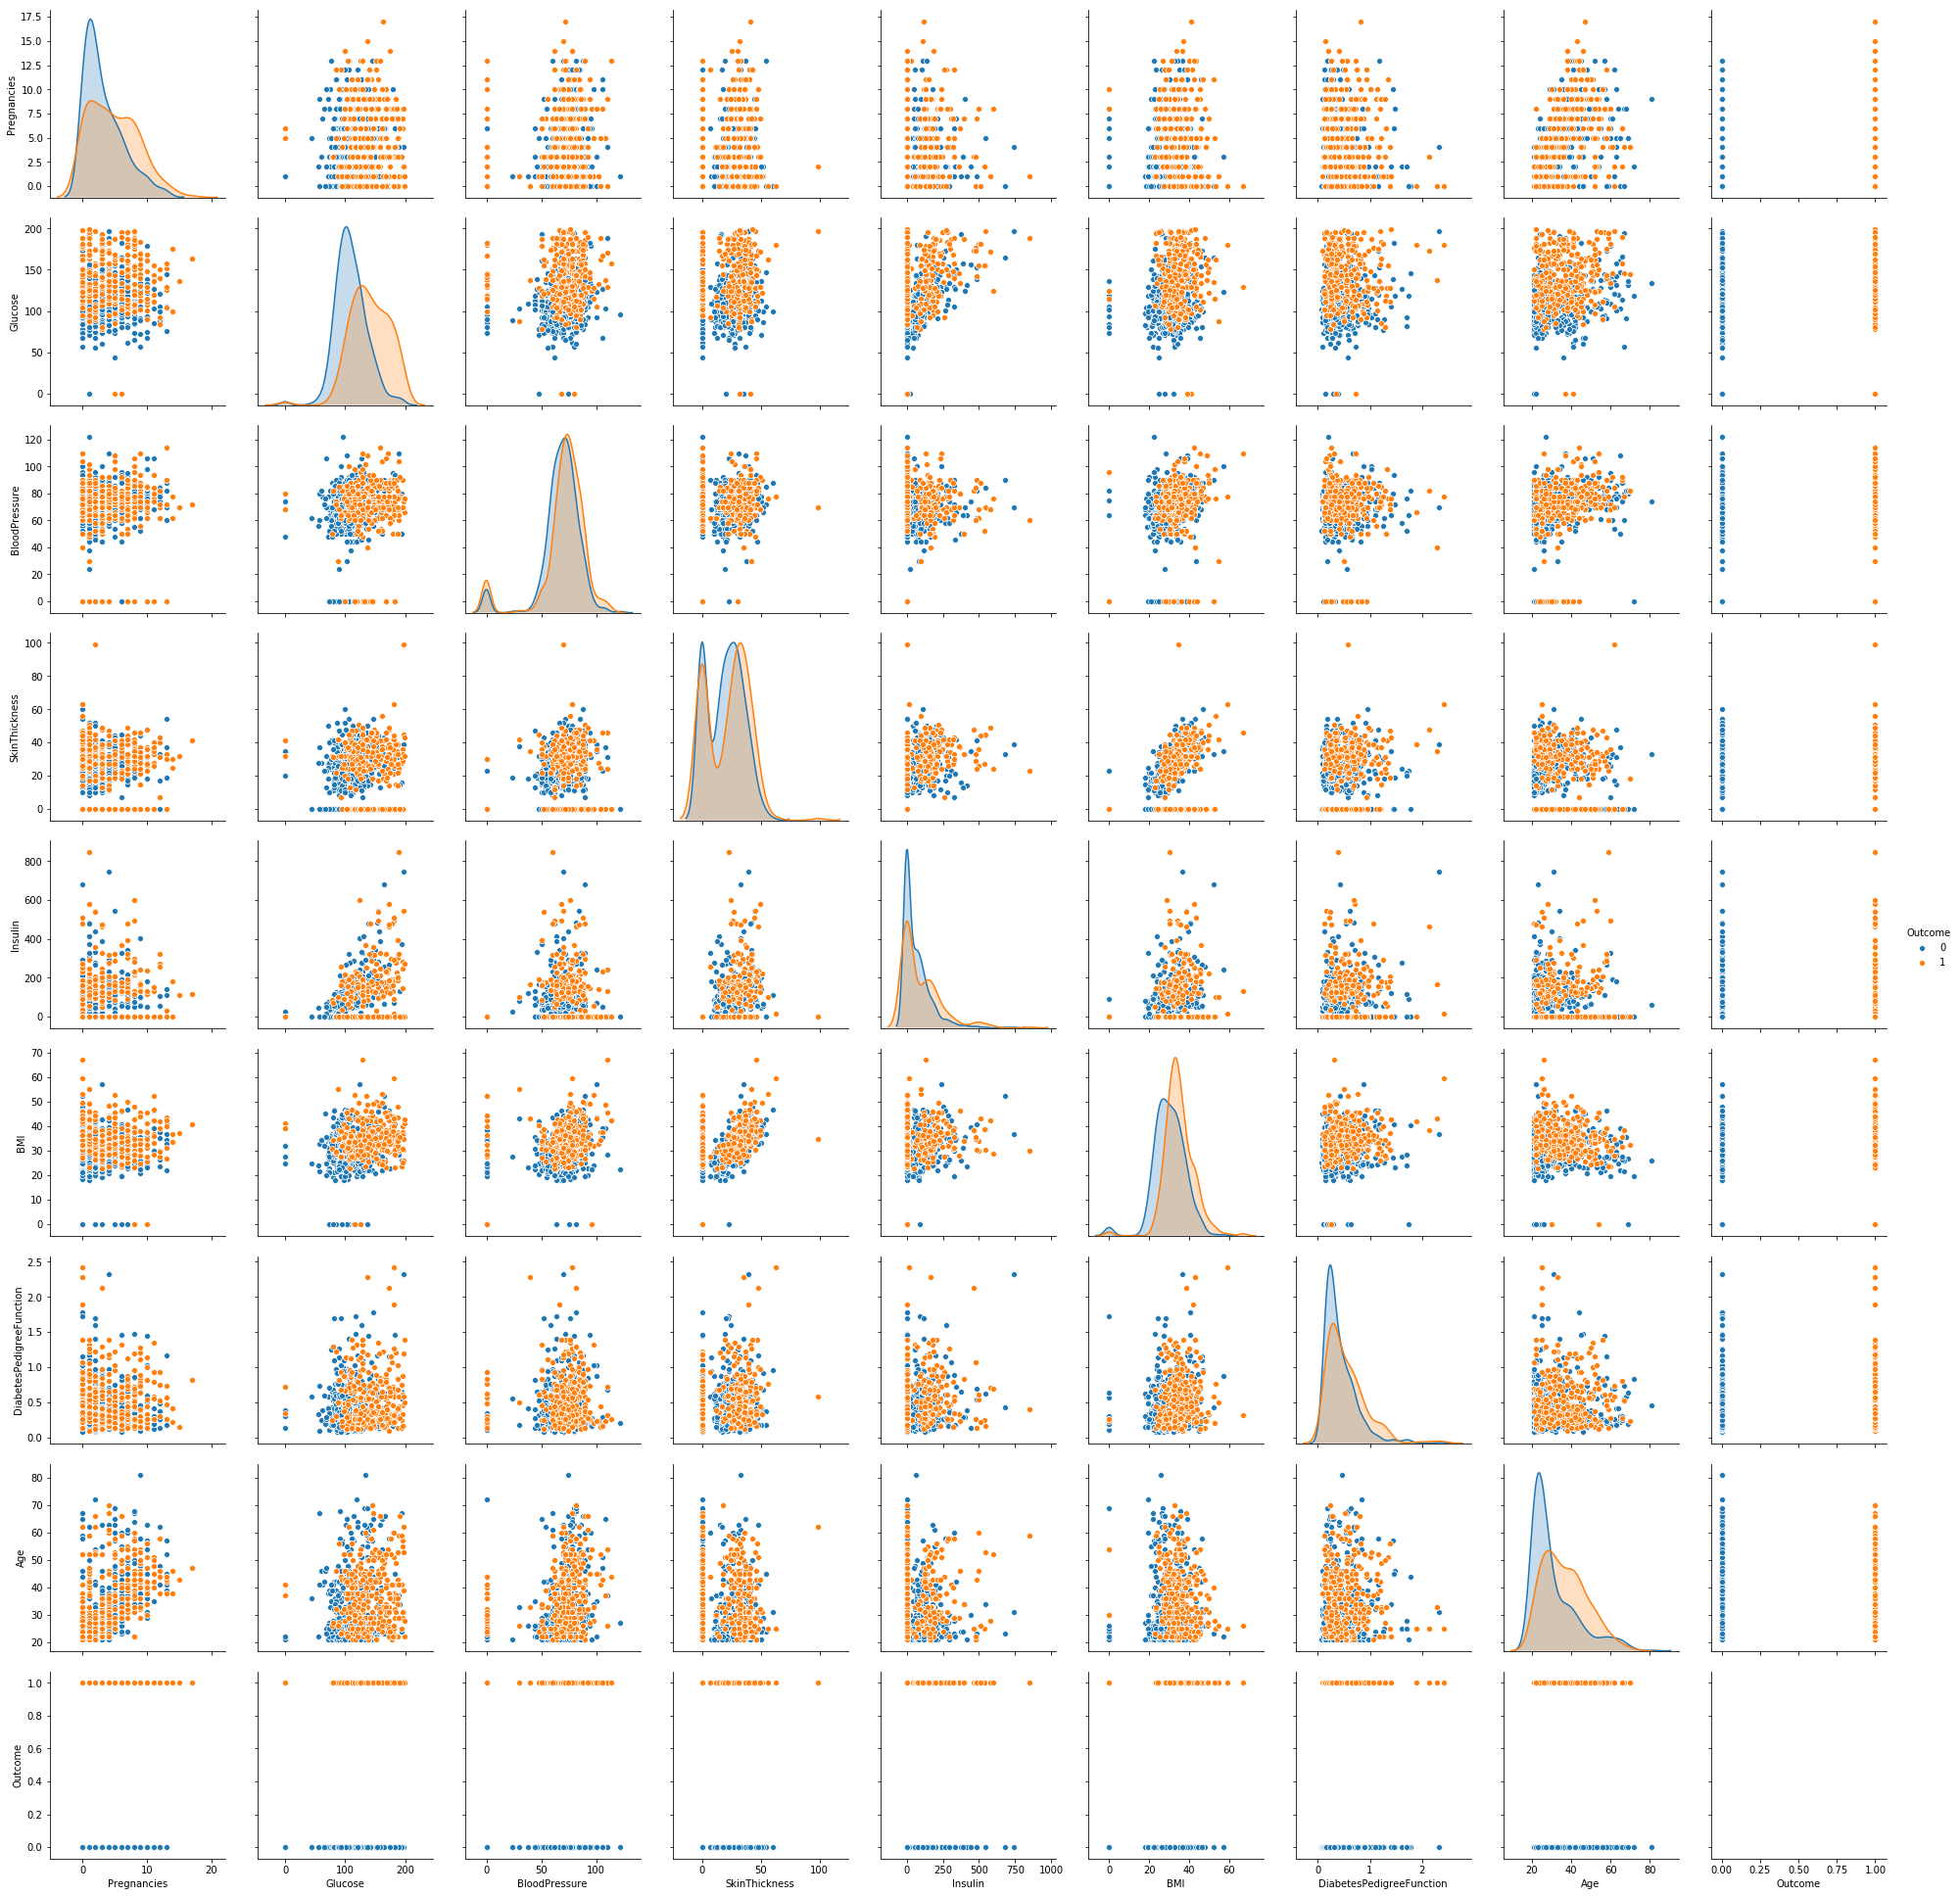

In [10]:
sns.pairplot(df, hue='Outcome', size=3, diag_kind="kde")

## 数据预处理

In [7]:
def normalize_feature_z_score(df):
    df1 = df.iloc[:,:-1].apply(lambda column:(column - column.mean())/column.std())
    return df1.join(df.iloc[:,-1])

def normalize_feature(df):
    df1 = df.iloc[:,:-1].apply(lambda column:((column - column.min()) /( column.max() - column.min()) - 0.5))
    return df1.join(df.iloc[:,-1])          

## 优化算法及其他函数

In [68]:
def sigmoid(X):
    return 1 / (1 + np.exp(-X))


def get_predictions(prob):
    prob[prob>0.5] = 1
    prob[prob<0.5] = 0
    return prob.astype(int)

def cross_entropy_loss(prob, y):
    return np.mean(-y * np.log(prob) - (1 - y) * np.log(1 - prob))


def get_gradient(predictions, X, y):
    return np.dot(X.T, predictions - y) / X.shape[0]
 
def BGD(X, y, scorefunc, epoch=500, lr=0.01, tol=1e-7, penalty="L2", gamma=0):
    '''
    用梯度下降拟合线性回归
    返回参数和代价
    '''
    m, n = X.shape
    loss_data = []
    theta = np.random.randn(n)
    for i in range(epoch):
        y_prob = scorefunc(np.dot(X, theta))
        loss = cross_entropy_loss(y_prob, y)
        order = 2 if penalty == "L2" else 1
        loss += 0.5 * gamma * np.linalg.norm(theta, ord=order) ** 2 / m
        loss_data.append(loss)
        if loss < tol:
            return theta, loss_data
        gradient_theta = get_gradient(y_prob, X, y)
        theta -= lr * gradient_theta
        if i%100==99:
            print('epoch %d: loss:%f' % (i, loss))
    return theta, loss_data


def SGD(X, y, scorefunc, epoch=500, lr=0.01, tol=1e-7, penalty="L2", gamma=0, batch_num=5):
    m,n = X.shape
    loss_data = []
    theta = np.random.randn(n)   
    indexs = np.arange(m)
    for i in range(epoch):
        np.random.shuffle(indexs)
        indices = np.array_split(indexs, batch_num) 
        for index in indices:
            X_index = X[index]
            y_index = y[index]
            y_prob = scorefunc(np.dot(X_index, theta))
            loss = cross_entropy_loss(y_prob, y_index)
            order = 2 if penalty == "L2" else 1
            loss += 0.5 * gamma * np.linalg.norm(theta, ord=order) ** 2 / m
            loss_data.append(loss)
            if loss < tol:
                return theta, loss_data
            gradient_theta = get_gradient(y_prob, X_index, y_index)
            theta -= lr * gradient_theta
        if i%100==99:
                print('epoch %d: loss:%f' % (i, loss))
    return theta, loss_data

def momentum(X, y, scorefunc,epoch=500, lr=0.01, tol=1e-7, penalty="L2", gamma=0, beta=0.9):
    m, n = X.shape
    loss_data = []
    theta = np.random.randn(n)
    v = np.zeros(n)
    for i in range(epoch):
        y_prob = scorefunc(np.dot(X, theta))
        loss = cross_entropy_loss(y_prob, y)
        order = 2 if penalty == "L2" else 1
        loss += 0.5 * gamma * np.linalg.norm(theta, ord=order) ** 2 / m
        loss_data.append(loss)
        if loss < tol:
            return theta, loss_data
        gradient_theta = get_gradient(y_prob, X, y)        
        v = v * beta + gradient_theta
        theta -= lr * v
        if i%100==99:
            print('epoch %d: loss:%f' % (i, loss))
    return theta, loss_data

def nesterov(X, y, scorefunc, epoch=500, lr=0.01,tol=1e-7, penalty="L2", gamma=0, beta=0.9):
    m,n = X.shape
    loss_data = []
    theta = np.random.randn(n)
    v = np.zeros(n)
    for i in range(epoch):
        y_prob = scorefunc(np.dot(X, theta - lr * beta * v))
        loss = cross_entropy_loss(y_prob, y)
        order = 2 if penalty == "L2" else 1
        loss += 0.5 * gamma * np.linalg.norm(theta, ord=order) ** 2 / m
        loss_data.append(loss)
        if loss < tol:
            return theta, loss_data
        gradient_theta = get_gradient(y_prob, X, y) 
        v = v * beta + gradient_theta
        theta -= v * lr
        if i%100==99:
            print('epoch %d: loss:%f' % (i, loss))
    return theta, loss_data

def adaGrad(X, y, scorefunc, epoch=500, lr=0.01, tol=1e-7, penalty="L2", gamma=0):
    m, n = X.shape
    loss_data = []
    theta = np.random.randn(n)
    G = np.zeros(n)
    eps = 1e-7
    for i in range(epoch):
        y_prob = scorefunc(np.dot(X, theta))
        loss = cross_entropy_loss(y_prob, y)
        order = 2 if penalty == "L2" else 1
        loss += 0.5 * gamma * np.linalg.norm(theta, ord=order) ** 2 / m
        loss_data.append(loss)
        if loss < tol:
            return theta, loss_data
        gradient_theta = get_gradient(y_prob, X, y)
        G += gradient_theta ** 2
        theta -= lr/(np.sqrt(G + eps)) * gradient_theta
        if i%100==99:
            print('epoch %d: loss:%f' % (i, loss))
    return theta, loss_data

## logistic模型构建

In [43]:
class LogisticRegression():
    def __init__(self, scorefunc=sigmoid, optimizor=BGD, fit_intercept=True, penalty="L2", gamma=0):
        '''
        参数：
        scorefuc：激活函数
        optimizor：梯度优化函数
        fit_intercept：是否在X前面加一列1，将b内置到theta
        penalty:正则化，可选"L1","L2"
        gamma:正则化项的系数
        '''
        self.optimizor = optimizor
        self.scorefunc = scorefunc
        self.theta = None
        self.fit_intercept = fit_intercept
        self.penalty = penalty
        self.gamma = gamma
        
    def fit(self, X, y, epoch=500, lr=0.01, tol=1e-7):
        if self.fit_intercept:
            X = np.c_[np.ones(X.shape[0]), X]

        theta, loss_data= self.optimizor(X, y, self.scorefunc, epoch, lr, tol, self.penalty, self.gamma)
        self.theta = theta
        return loss_data
        
    def predict(self, X):
        if self.fit_intercept:
            X = np.c_[np.ones(X.shape[0]), X]
        prob = self.scorefunc(np.dot(X, self.theta))
        predictions = get_predictions(prob)
        return predictions

In [48]:
feature_cols = df.columns[:]
choose_cols = ['Glucose','BloodPressure','SkinThickness','Outcome']
df_ = df.loc[:,feature_cols]
list(df_.columns)

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

In [49]:
df_nol = normalize_feature(df_)
X = df_nol.iloc[:450,:-1]
y = df_nol.iloc[:450,-1]
X_val = df_nol.iloc[450:600,:-1]
y_val = df_nol.iloc[450:600,-1]
X_test = df_nol.iloc[601:,:-1]
y_test = df_nol.iloc[601:, -1]

In [50]:
X.shape
df_nol.shape

(768, 9)

In [51]:
df_nol.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,-0.273820,0.107510,0.066438,-0.292561,-0.405674,-0.023210,-0.331821,-0.295985,0.348958
std,0.198210,0.160666,0.158654,0.161134,0.136222,0.117499,0.141473,0.196004,0.476951
min,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,0.000000
25%,-0.441176,-0.002513,0.008197,-0.500000,-0.500000,-0.093145,-0.429227,-0.450000,0.000000
50%,-0.323529,0.087940,0.090164,-0.267677,-0.463948,-0.023100,-0.374253,-0.366667,0.000000
75%,-0.147059,0.204774,0.155738,-0.176768,-0.349586,0.045455,-0.265905,-0.166667,1.000000
max,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.000000


## logistic回归SGD测试

In [55]:
acc_gamma = {}
model = []
for gamma in np.linspace(0,4,20):
    LGR_1 = LogisticRegression(gamma=gamma,optimizor=SGD)
    loss_data = LGR_1.fit(X, y)
    predictions_LGR_1 = LGR_1.predict(X_val)
    acc = np.mean(predictions_LGR_1==y_val)
    acc_gamma[gamma] = acc
    model.append(LGR_1)
    print("gamma:%f,acc:%f"%(gamma, acc))

epoch 99: loss:0.665282
epoch 199: loss:0.743285
epoch 299: loss:0.669560
epoch 399: loss:0.603049
epoch 499: loss:0.648075
gamma:0.000000,acc:0.753333
epoch 99: loss:0.727026
epoch 199: loss:0.761284
epoch 299: loss:0.787742
epoch 399: loss:0.722065
epoch 499: loss:0.737962
gamma:0.210526,acc:0.753333
epoch 99: loss:0.714839
epoch 199: loss:0.702467
epoch 299: loss:0.751196
epoch 399: loss:0.668432
epoch 499: loss:0.688118
gamma:0.421053,acc:0.726667
epoch 99: loss:0.615878
epoch 199: loss:0.682918
epoch 299: loss:0.690286
epoch 399: loss:0.660229
epoch 499: loss:0.627628
gamma:0.631579,acc:0.733333
epoch 99: loss:0.721069
epoch 199: loss:0.739997
epoch 299: loss:0.685746
epoch 399: loss:0.655272
epoch 499: loss:0.604962
gamma:0.842105,acc:0.773333
epoch 99: loss:0.660514
epoch 199: loss:0.625244
epoch 299: loss:0.648070
epoch 399: loss:0.562930
epoch 499: loss:0.623587
gamma:1.052632,acc:0.766667
epoch 99: loss:0.632533
epoch 199: loss:0.621863
epoch 299: loss:0.600334
epoch 399: los

In [56]:
for gamma, acc in acc_gamma.items():
    print("gamma:%.4f, acc:%.4f" % (gamma, acc))

gamma:0.0000, acc:0.7533
gamma:0.2105, acc:0.7533
gamma:0.4211, acc:0.7267
gamma:0.6316, acc:0.7333
gamma:0.8421, acc:0.7733
gamma:1.0526, acc:0.7667
gamma:1.2632, acc:0.7667
gamma:1.4737, acc:0.8000
gamma:1.6842, acc:0.7400
gamma:1.8947, acc:0.7867
gamma:2.1053, acc:0.7333
gamma:2.3158, acc:0.7267
gamma:2.5263, acc:0.7667
gamma:2.7368, acc:0.8000
gamma:2.9474, acc:0.7600
gamma:3.1579, acc:0.7533
gamma:3.3684, acc:0.7867
gamma:3.5789, acc:0.7933
gamma:3.7895, acc:0.7867
gamma:4.0000, acc:0.7600


## momentum

In [58]:
acc_gamma = {}
for gamma in np.linspace(0,4,20):
    LGR_4 = LogisticRegression(gamma=gamma,optimizor=momentum)
    loss_data = LGR_4.fit(X, y)
    predictions_LGR_4 = LGR_4.predict(X_val)
    acc = np.mean(predictions_LGR_4==y_val)
    acc_gamma[gamma] = acc
    print("gamma:%f,acc:%f"%(gamma, acc))

epoch 99: loss:0.677344
epoch 199: loss:0.652384
epoch 299: loss:0.632150
epoch 399: loss:0.615642
epoch 499: loss:0.602061
gamma:0.000000,acc:0.760000
epoch 99: loss:0.637316
epoch 199: loss:0.623063
epoch 299: loss:0.610899
epoch 399: loss:0.600442
epoch 499: loss:0.591393
gamma:0.210526,acc:0.773333
epoch 99: loss:0.694909
epoch 199: loss:0.666026
epoch 299: loss:0.642416
epoch 399: loss:0.623117
epoch 499: loss:0.607308
gamma:0.421053,acc:0.740000
epoch 99: loss:0.660529
epoch 199: loss:0.637425
epoch 299: loss:0.619002
epoch 399: loss:0.604239
epoch 499: loss:0.592333
gamma:0.631579,acc:0.800000
epoch 99: loss:0.625323
epoch 199: loss:0.612700
epoch 299: loss:0.602256
epoch 399: loss:0.593545
epoch 499: loss:0.586233
gamma:0.842105,acc:0.746667
epoch 99: loss:0.668215
epoch 199: loss:0.645809
epoch 299: loss:0.627595
epoch 399: loss:0.612791
epoch 499: loss:0.600754
gamma:1.052632,acc:0.720000
epoch 99: loss:0.648834
epoch 199: loss:0.632838
epoch 299: loss:0.619483
epoch 399: los

In [60]:
for gamma, acc in acc_gamma.items():
    print("gamma:%.4f, acc:%.4f" % (gamma, acc))

gamma:0.0000, acc:0.8000
gamma:0.2105, acc:0.7400
gamma:0.4211, acc:0.7600
gamma:0.6316, acc:0.8200
gamma:0.8421, acc:0.7667
gamma:1.0526, acc:0.7600
gamma:1.2632, acc:0.7667
gamma:1.4737, acc:0.7867
gamma:1.6842, acc:0.7533
gamma:1.8947, acc:0.7533
gamma:2.1053, acc:0.7800
gamma:2.3158, acc:0.7667
gamma:2.5263, acc:0.7733
gamma:2.7368, acc:0.7467
gamma:2.9474, acc:0.7867
gamma:3.1579, acc:0.7467
gamma:3.3684, acc:0.7867
gamma:3.5789, acc:0.7667
gamma:3.7895, acc:0.7400
gamma:4.0000, acc:0.7133


## logistic回归nesterov优化测试

In [59]:
acc_gamma = {}
for gamma in np.linspace(0,4,20):
    LGR_6 = LogisticRegression(gamma=gamma,optimizor=nesterov)
    loss_data = LGR_6.fit(X, y)
    predictions_LGR_6 = LGR_6.predict(X_val)
    acc = np.mean(predictions_LGR_6==y_val)
    acc_gamma[gamma] = acc
    print("gamma:%f,acc:%f"%(gamma, acc))

epoch 99: loss:0.600964
epoch 199: loss:0.586991
epoch 299: loss:0.575628
epoch 399: loss:0.566292
epoch 499: loss:0.558545
gamma:0.000000,acc:0.800000
epoch 99: loss:0.685122
epoch 199: loss:0.662076
epoch 299: loss:0.642571
epoch 399: loss:0.625997
epoch 499: loss:0.611859
gamma:0.210526,acc:0.740000
epoch 99: loss:0.666915
epoch 199: loss:0.646448
epoch 299: loss:0.629722
epoch 399: loss:0.615932
epoch 499: loss:0.604456
gamma:0.421053,acc:0.760000
epoch 99: loss:0.590506
epoch 199: loss:0.579934
epoch 299: loss:0.571444
epoch 399: loss:0.564586
epoch 499: loss:0.559016
gamma:0.631579,acc:0.820000
epoch 99: loss:0.599754
epoch 199: loss:0.590317
epoch 299: loss:0.582517
epoch 399: loss:0.576039
epoch 499: loss:0.570635
gamma:0.842105,acc:0.766667
epoch 99: loss:0.582289
epoch 199: loss:0.575577
epoch 299: loss:0.570209
epoch 399: loss:0.565891
epoch 499: loss:0.562404
gamma:1.052632,acc:0.760000
epoch 99: loss:0.771907
epoch 199: loss:0.730843
epoch 299: loss:0.697708
epoch 399: los

In [70]:
for gamma, acc in acc_gamma.items():
    print("gamma:%.4f, acc:%.4f" % (gamma, acc))

gamma:0.0000, acc:0.7200
gamma:0.2105, acc:0.7600
gamma:0.4211, acc:0.7667
gamma:0.6316, acc:0.2467
gamma:0.8421, acc:0.2400
gamma:1.0526, acc:0.7200
gamma:1.2632, acc:0.6533
gamma:1.4737, acc:0.2400
gamma:1.6842, acc:0.7133
gamma:1.8947, acc:0.7467
gamma:2.1053, acc:0.7867
gamma:2.3158, acc:0.5467
gamma:2.5263, acc:0.7533
gamma:2.7368, acc:0.6933
gamma:2.9474, acc:0.7533
gamma:3.1579, acc:0.7667
gamma:3.3684, acc:0.7667
gamma:3.5789, acc:0.7600
gamma:3.7895, acc:0.7267
gamma:4.0000, acc:0.7800


## ladaGrad优化测试

In [69]:
acc_gamma = {}
for gamma in np.linspace(0,4,20):
    LGR_6 = LogisticRegression(gamma=gamma,optimizor=adaGrad)
    loss_data = LGR_6.fit(X, y)
    predictions_LGR_6 = LGR_6.predict(X_val)
    acc = np.mean(predictions_LGR_6==y_val)
    acc_gamma[gamma] = acc
    print("gamma:%f,acc:%f"%(gamma, acc))

epoch 99: loss:0.699383
epoch 199: loss:0.672366
epoch 299: loss:0.657434
epoch 399: loss:0.647852
epoch 499: loss:0.641165
gamma:0.000000,acc:0.720000
epoch 99: loss:0.695343
epoch 199: loss:0.684672
epoch 299: loss:0.676976
epoch 399: loss:0.670798
epoch 499: loss:0.665578
gamma:0.210526,acc:0.760000
epoch 99: loss:0.678597
epoch 199: loss:0.657646
epoch 299: loss:0.646422
epoch 399: loss:0.639242
epoch 499: loss:0.634114
gamma:0.421053,acc:0.766667
epoch 99: loss:0.965053
epoch 199: loss:0.893748
epoch 299: loss:0.846329
epoch 399: loss:0.811020
epoch 499: loss:0.783293
gamma:0.631579,acc:0.246667
epoch 99: loss:2.217919
epoch 199: loss:2.079929
epoch 299: loss:1.976232
epoch 399: loss:1.890520
epoch 499: loss:1.816474
gamma:0.842105,acc:0.240000
epoch 99: loss:0.756911
epoch 199: loss:0.722069
epoch 299: loss:0.701988
epoch 399: loss:0.688698
epoch 499: loss:0.679219
gamma:1.052632,acc:0.720000
epoch 99: loss:0.760083
epoch 199: loss:0.710682
epoch 299: loss:0.680863
epoch 399: los

In [71]:
for gamma, acc in acc_gamma.items():
    print("gamma:%.4f, acc:%.4f" % (gamma, acc))

gamma:0.0000, acc:0.7200
gamma:0.2105, acc:0.7600
gamma:0.4211, acc:0.7667
gamma:0.6316, acc:0.2467
gamma:0.8421, acc:0.2400
gamma:1.0526, acc:0.7200
gamma:1.2632, acc:0.6533
gamma:1.4737, acc:0.2400
gamma:1.6842, acc:0.7133
gamma:1.8947, acc:0.7467
gamma:2.1053, acc:0.7867
gamma:2.3158, acc:0.5467
gamma:2.5263, acc:0.7533
gamma:2.7368, acc:0.6933
gamma:2.9474, acc:0.7533
gamma:3.1579, acc:0.7667
gamma:3.3684, acc:0.7667
gamma:3.5789, acc:0.7600
gamma:3.7895, acc:0.7267
gamma:4.0000, acc:0.7800


In [294]:
predictions = log_model.predict(X_valid)
precision, recall, f1_score = classification_report(predictions, y_valid)
acc = (predictions==y_valid).sum()/y_valid.shape
print('optimizor:%s\tfeature:%s\t epoch:%d\talpha:%d \tprecision:%f \t recall:%d\t f1_score:%f \t acc:%f'%( optimizor,list(df_.columns),epoch, alpha, precision, recall, f1_score, acc))
with open('report.txt','a') as f:
    f.write('optimizor:%s\tfeature:%s\t epoch:%d\talpha:%d \tprecision:%f \t recall:%d\t f1_score:%f \t acc:%f\n'%( str(optimizor),list(df_.columns),epoch, alpha, precision, recall, f1_score, acc))

precision: 0.714286, recall: 0.113636, f1_score: 0.196078
optimizor:<function BGD at 0x7f03ac60bbf8>	feature:['Glucose', 'BloodPressure', 'SkinThickness', 'Outcome']	 epoch:500	alpha:0 	precision:0.714286 	 recall:0	 f1_score:0.196078 	 acc:0.674603


## SGD

In [26]:
df_nol = normalize_feature(df_)
num_folds = 10
folds = k_fold(df_nol, num_folds)
acc_list = []
for i in range(num_folds):
    test_data = folds.pop(-num_folds+1).reset_index()
    train_data = pd.concat(folds).reset_index()
    folds.append(test_data)
    X_train = train_data.iloc[:,:-1]
    print(X_train.shape)
    y_train = train_data.iloc[:,-1]
    X_test = test_data.iloc[:,:-1]
    y_test = test_data.iloc[:,-1]
    log_model = LogisticRegression()
    loss_data = log_model.fit(X_train, y_train)
    predictions = log_model.predict(X_test)
    acc = (predictions==y_test).mean()/y_test.shape
    acc_list.append(acc)
    print(acc)
    break
    
    
    
    

(691, 4)


/home/lyf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


epoch 99: loss:26.248799
epoch 199: loss:inf
epoch 299: loss:inf
epoch 399: loss:inf
epoch 499: loss:inf
[0.00877045]


In [67]:
ones = pd.DataFrame({'ones': np.ones(train_data.shape[0])})
data = pd.concat([ones, train_data.reset_index()], axis=1)
data.shape

(691, 6)

In [70]:
train_data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1
